<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [13]:
import os
import sys
import cv2
import dlib
import numpy as np
import math
import matplotlib.pylab as plt

In [2]:
def readImagePaths(path):
  # Create array of array of images.
  imagePaths = []
  # List all files in the directory and read points from text files one by one
  for filePath in sorted(os.listdir(path)):
    fileExt = os.path.splitext(filePath)[1]
    if fileExt in [".jpg", ".jpeg"]:
      print(filePath)

      # Add to array of images
      imagePaths.append(os.path.join(path, filePath))

  return imagePaths



In [3]:
# Returns 8 points on the boundary of a rectangle
def getEightBoundaryPoints(h, w):
  boundaryPts = []
  boundaryPts.append((0,0))
  boundaryPts.append((w/2, 0))
  boundaryPts.append((w-1,0))
  boundaryPts.append((w-1, h/2))
  boundaryPts.append((w-1, h-1))
  boundaryPts.append((w/2, h-1))
  boundaryPts.append((0, h-1))
  boundaryPts.append((0, h/2))
  return np.array(boundaryPts, dtype=np.float)


In [4]:
def normalizeImagesAndLandmarks(outSize, imIn, pointsIn):
  h, w = outSize
  # Corners of the eye in input image
  eyecornerSrc = [pointsIn[36], pointsIn[45]]

  # Corners of the eye in normalized image
  eyecornerDst = [(np.int(0.3 * w), np.int(h/3)), 
                  (np.int(0.7 * w), np.int(h/3))]

  # Calculate similarity transform
  tform = similarityTransform(eyecornerSrc, eyecornerDst)
  imOut = np.zeros(imIn.shape, dtype=imIn.dtype)
  # Apply similarity transform to input image
  imOut = cv2.warpAffine(imIn, tform, (w, h))
  # reshape pointsIn from numLandmarks x 2 to numLandmarks x 1 x 2
  points2 = np.reshape(pointsIn, (pointsIn.shape[0], 1, pointsIn.shape[1]))
    
  pointsOut = cv2.transform(points2, tform)
  pointsOut = np.reshape(pointsOut, (pointsIn.shape[0], pointsIn.shape[1]))

  return imOut, pointsOut

def similarityTransform(inPoints, outPoints):
  s60 = math.sin(60*math.pi/180)
  c60 = math.cos(60*math.pi/180)

  inPts = np.copy(inPoints).tolist()
  outPts = np.copy(outPoints).tolist()

  # The third point is calculated so that the three points make an equilateral triangle
  xin = c60*(inPts[0][0] - inPts[1][0]) - s60*(inPts[0][1] - inPts[1][1]) + inPts[1][0]
  yin = s60*(inPts[0][0] - inPts[1][0]) + c60*(inPts[0][1] - inPts[1][1]) + inPts[1][1]

  inPts.append([np.int(xin), np.int(yin)])

  xout = c60*(outPts[0][0] - outPts[1][0]) - s60*(outPts[0][1] - outPts[1][1]) + outPts[1][0]
  yout = s60*(outPts[0][0] - outPts[1][0]) + c60*(outPts[0][1] - outPts[1][1]) + outPts[1][1]

  outPts.append([np.int(xout), np.int(yout)])

  # estimateRigidTransform for calculating the similarity transform.
  tform = cv2.estimateRigidTransform(np.array([inPts]), np.array([outPts]), False)
  return tform


In [5]:
# convert Dlib shape detector object to list of tuples
def dlibLandmarksToPoints(shape):
  points = []
  for p in shape.parts():
    pt = (p.x, p.y)
    points.append(pt)
  return points

# Dlib Landmark Detector
def getLandmarks(faceDetector, landmarkDetector, im, FACE_DOWNSAMPLE_RATIO = 1):
  points = []
  imSmall = cv2.resize(im,None,
                       fx=1.0/FACE_DOWNSAMPLE_RATIO, 
                       fy=1.0/FACE_DOWNSAMPLE_RATIO, 
                       interpolation = cv2.INTER_LINEAR)
  
  faceRects = faceDetector(imSmall, 0)
  
  if len(faceRects) > 0:
    maxArea = 0
    maxRect = None
    # TODO: test on images with multiple faces
    for face in faceRects:
      if face.area() > maxArea:
        maxArea = face.area()
        maxRect = [face.left(),
                   face.top(),
                   face.right(),
                   face.bottom()
                  ]
    
    rect = dlib.rectangle(*maxRect)
    scaledRect = dlib.rectangle(int(rect.left()*FACE_DOWNSAMPLE_RATIO),
                             int(rect.top()*FACE_DOWNSAMPLE_RATIO),
                             int(rect.right()*FACE_DOWNSAMPLE_RATIO),
                             int(rect.bottom()*FACE_DOWNSAMPLE_RATIO))
    
    landmarks = landmarkDetector(im, scaledRect)
    points = dlibLandmarksToPoints(landmarks)
  return points


In [6]:
# Check if a point is inside a rectangle
def rectContains(rect, point):
  if point[0] < rect[0]:
    return False
  elif point[1] < rect[1]:
    return False
  elif point[0] > rect[2]:
    return False
  elif point[1] > rect[3]:
    return False
  return True

# Calculate Delaunay triangles for set of points

def calculateDelaunayTriangles(rect, points):
  subdiv = cv2.Subdiv2D(rect)
  for p in points:
    subdiv.insert((p[0], p[1]))
  # Get Delaunay triangulation
  triangleList = subdiv.getTriangleList()
  delaunayTri = []
  for t in triangleList:
    # The triangle returned by getTriangleList 
    pt = []
    pt.append((t[0], t[1]))
    pt.append((t[2], t[3]))
    pt.append((t[4], t[5]))

    pt1 = (t[0], t[1])
    pt2 = (t[2], t[3])
    pt3 = (t[4], t[5])

    if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
      ind = []
      # Find the index of each vertex in the points list
      for j in range(0, 3):
        for k in range(0, len(points)):
          if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
            ind.append(k)
        # Store triangulation as a list of indices
      if len(ind) == 3:
        delaunayTri.append((ind[0], ind[1], ind[2]))

  return delaunayTri

In [7]:
# Apply affine transform 
def applyAffineTransform(src, srcTri, dstTri, size):

  # Given a pair of triangles, find the affine transform.
  warpMat = cv2.getAffineTransform(np.float32(srcTri), np.float32(dstTri))

  # Apply the Affine Transform just found to the src image
  dst = cv2.warpAffine(src, warpMat, (size[0], size[1]), None,
             flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

  return dst

In [8]:
# Constrains points to be inside boundary
def constrainPoint(p, w, h):
  p = (min(max(p[0], 0), w - 1), min(max(p[1], 0), h - 1))
  return p

def warpImage(imIn, pointsIn, pointsOut, delaunayTri):
  h, w, ch = imIn.shape
  # Output image
  imOut = np.zeros(imIn.shape, dtype=imIn.dtype)
  for j in range(0, len(delaunayTri)):
    tin = []
    tout = []

    for k in range(0, 3):
      # Extract a vertex of input triangle
      pIn = pointsIn[delaunayTri[j][k]]
      pIn = constrainPoint(pIn, w, h)
      pOut = pointsOut[delaunayTri[j][k]]
      pOut = constrainPoint(pOut, w, h)
      tin.append(pIn)
      tout.append(pOut)

    # Warp pixels inside input triangle to output triangle.
    warpTriangle(imIn, imOut, tin, tout)
  return imOut

def warpTriangle(img1, img2, t1, t2):
  # Find bounding rectangle for each triangle
  r1 = cv2.boundingRect(np.float32([t1]))
  r2 = cv2.boundingRect(np.float32([t2]))
  t1Rect = []
  t2Rect = []
  t2RectInt = []

  for i in range(0, 3):
    t1Rect.append(((t1[i][0] - r1[0]), (t1[i][1] - r1[1])))
    t2Rect.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))
    t2RectInt.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))

  # Get mask by filling triangle
  mask = np.zeros((r2[3], r2[2], 3), dtype=np.float32)
  cv2.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0)
  img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
  size = (r2[2], r2[3])
  img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)
  img2Rect = img2Rect * mask
   # Copy triangular region of the rectangular patch to the output image
  img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ((1.0, 1.0, 1.0) - mask)
  img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect

102-CPP_1535611560.jpg
105-NOR_1535611560.jpg
106-NOR_1535611560.jpg
109-NOR_1535611560.jpg
112-NOR_1535611574.jpg
113-NOR_1535611574.jpg
114-NOR_1535611574.jpg
115-NOR_1535611574.jpg
118-NOR_1535611588.jpg
124-NOR_1535611588.jpg
125-NOR_1535611588.jpg
129-NOR_1535611588.jpg
130-NOR_1535611602.jpg
132-SGA_1535611602.jpg
136-CPP_1535611602.jpg
137-CPP_1535611602.jpg
140-NOR_1535611615.jpg
141-NOR_1535611615.jpg
146-NOR_1535611615.jpg
149-CPP_1535611615.jpg
15-CPP_1535611628.jpg
150-NOR_1535611629.jpg
153-NOR_1535611629.jpg
154-GHD_1535611629.jpg
155-NOR_1535611641.jpg
156-NOR_1535611642.jpg
159-ISS_1535611642.jpg
160-NOR_1535611642.jpg
164-NOR_1535611655.jpg
166-NOR_1535611656.jpg
167-NOR_1535611656.jpg
17-ISS_1535611656.jpg
170-NOR_1535611669.jpg
171-NOR_1535611669.jpg
172-NOR_1535611669.jpg
173-NOR_1535611670.jpg
175-SGA_1535611682.jpg
176-NOR_1535611682.jpg
184-CPP_1535611676.jpg
185-NOR_1535611676.jpg
194-CPP_1535611689.jpg
196-MAS_1535611689.jpg
198-NOR_1535611696.jpg
200-NOR_15356

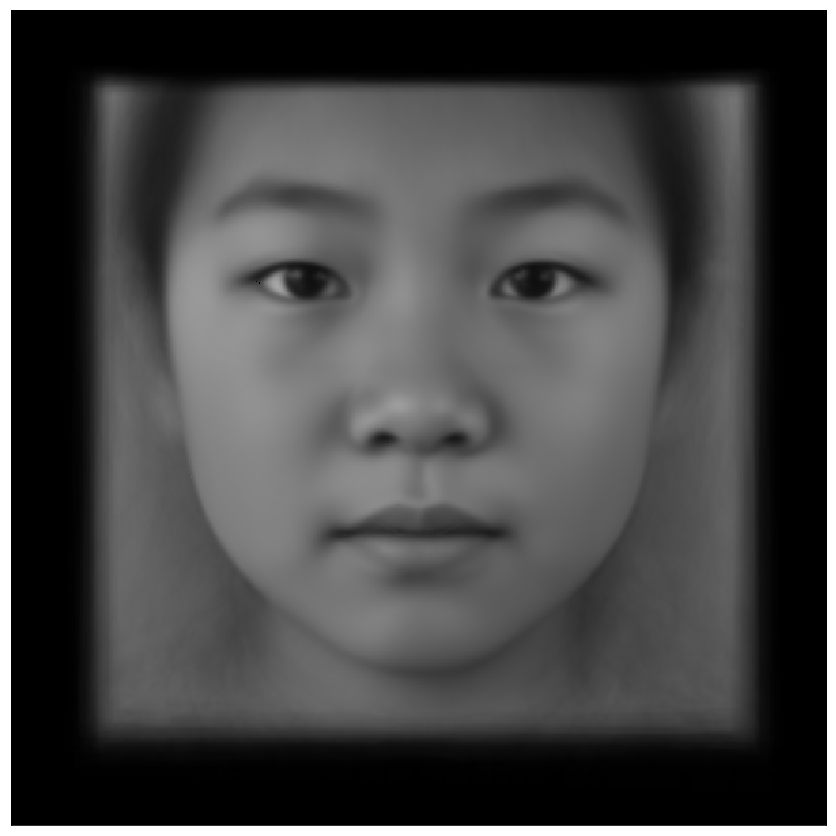

In [17]:
if __name__ == '__main__':
  import dataset


  PREDICTER_5_PATH = dataset.LANDMARKS_5_PATH
  PREDICTER_68_PATH = dataset.LANDMARKS_68_PATH
  # Landmark model location
  PREDICTOR_PATH = PREDICTER_68_PATH
  faceDetector = dlib.get_frontal_face_detector()
  # The landmark detector is implemented in the shape_predictor class
  landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)
  dirName = r"E:\pycharmpro\faceDig\dataset\image\test_t"
  # Read all images
  imagePaths = readImagePaths(dirName) 
  if len(imagePaths) == 0:
    print('No images found with extension jpg or jpeg')
    sys.exit(0)

  # Read images and perform landmark detection.
  images = []
  allPoints = []
  for imagePath in imagePaths:
    im = cv2.imread(imagePath)
    if im is None:
      print("image:{} not read properly".format(imagePath))
    else:
        points = getLandmarks(faceDetector, landmarkDetector, im)
        if len(points) > 0:
          allPoints.append(points)

          im = np.float32(im)/255.0
          images.append(im)
        else:
          print("Couldn't detect face landmarks")


  if len(images) == 0:
    print("No images found")
    sys.exit(0)
  # Dimensions of output image
  w = 600
  h = 600

  # 8 Boundary points for Delaunay Triangulation
  boundaryPts = getEightBoundaryPoints(h, w)

  numImages = len(imagePaths)
  numLandmarks = len(allPoints[0])

  # Variables to store normalized images and points.
  imagesNorm = []
  pointsNorm = []
  # Initialize location of average points to 0s
  pointsAvg = np.zeros((numLandmarks, 2), dtype=np.float32)

  # Warp images and trasnform landmarks to output coordinate system,
  # and find average of transformed landmarks.
  for i, img in enumerate(images):

    points = allPoints[i]
    points = np.array(points)

    img, points = normalizeImagesAndLandmarks((h, w), img, points)

    # Calculate average landmark locations
    pointsAvg = pointsAvg + (points / (1.0*numImages))

    # Append boundary points. Will be used in Delaunay Triangulation
    points = np.concatenate((points, boundaryPts), axis=0)

    pointsNorm.append(points)
    imagesNorm.append(img)
   # Append boundary points to average points.
  pointsAvg = np.concatenate((pointsAvg, boundaryPts), axis=0)

  # Delaunay triangulation
  rect = (0, 0, w, h)
  dt = calculateDelaunayTriangles(rect, pointsAvg)

  # Output image
  output = np.zeros((h, w, 3), dtype=np.float)

  # Warp input images to average image landmarks
  for i in range(0, numImages):

    imWarp = warpImage(imagesNorm[i], pointsNorm[i], pointsAvg.tolist(), dt)

    # Add image intensities for averaging
    output = output + imWarp

  # Divide by numImages to get average
  output = output / (1.0*numImages)
  #cv2.imwrite("finalpic1.jpg",output) 
  # Display result
  #cv2.imshow('image', output)
  #cv2.waitKey(0)  
  
  plt.figure(figsize=(15,15))
  plt.imshow(output)

  #output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
  cv2.imwrite("aaawn.jpg", output)
  plt.xticks([])
  plt.yticks([])
  plt.show()